# Visualização

Será utilizado como exemplo ações do mercado financeiro

## Pacotes

In [1]:
library(ggplot2)
library(quantmod)
library(RCurl)
library(dplyr)
library(tidyr)
library(magrittr)

Loading required package: xts
Loading required package: zoo

Attaching package: ‘zoo’

The following objects are masked from ‘package:base’:

    as.Date, as.Date.numeric

Loading required package: TTR
Version 0.4-0 included new data defaults. See ?getSymbols.
Loading required package: bitops

Attaching package: ‘dplyr’

The following objects are masked from ‘package:xts’:

    first, last

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:RCurl’:

    complete


Attaching package: ‘magrittr’

The following object is masked from ‘package:tidyr’:

    extract



## Obtenção dos dados

### Fonte

In [2]:
sit <- getURLContent('https://github.com/systematicinvestor/SIT/raw/master/sit.gz', binary=TRUE, followlocation = TRUE, ssl.verifypeer = FALSE)
con <- gzcon(rawConnection(sit, 'rb'))
source(con)
close(con)

### Busca os dados

In [3]:
tickers <- spl('^BVSP,PETR4.SA,VALE5.SA,USIM5.SA,ABEV3.SA,ITUB4.SA,BBDC4.SA,JBSS3.SA,GOLL4.SA')

dados <- new.env()
options( download.file.method="libcurl" )
getSymbols(tickers, src = 'yahoo', from = '2017-01-01', env = dados, auto.assign = T)

    As of 0.4-0, ‘getSymbols’ uses env=parent.frame() and
 auto.assign=TRUE by default.

 This  behavior  will be  phased out in 0.5-0  when the call  will
 default to use auto.assign=FALSE. getOption("getSymbols.env") and 
 getOptions("getSymbols.auto.assign") are now checked for alternate defaults

 This message is shown once per session and may be disabled by setting 
 options("getSymbols.warning4.0"=FALSE). See ?getSymbols for more details.
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols
pausing 1 second between requests for more than 5 symbols


[1] "BVSP"     "PETR4.SA" "VALE5.SA" "USIM5.SA" "ABEV3.SA" "ITUB4.SA" "BBDC4.SA"
[8] "JBSS3.SA" "GOLL4.SA"

### Ajusta os dados

In [4]:
# Somente os precos
for(i in ls(dados)) dados[[i]] = adjustOHLC(dados[[i]], use.Adjusted=T)                            
bt.prep(dados, align = 'remove.na')

### Obtem somente os preços

In [5]:
dados_precos <- dados$prices
dados_precos <- data.frame(data = index(dados_precos), dados_precos)
head(dados_precos)

,data,ABEV3.SA,BBDC4.SA,BVSP,GOLL4.SA,ITUB4.SA,JBSS3.SA,PETR4.SA,USIM5.SA,VALE5.SA
2017-01-02,2017-01-02,16.24416,26.0969,59589,4.51,32.84536,11.30,14.66,4.08,22.07962
2017-01-03,2017-01-03,16.57283,27.2039,61814,4.88,34.23636,11.45,15.50,4.29,23.29714
2017-01-04,2017-01-04,16.44335,27.0317,61589,5.17,34.38330,11.45,15.50,4.55,22.85265
2017-01-05,2017-01-05,16.53299,27.3309,62071,5.23,34.85350,11.42,15.75,4.60,23.91557
2017-01-06,2017-01-06,16.39355,27.5032,61665,5.15,34.97105,11.50,15.66,4.47,23.29714
2017-01-09,2017-01-09,16.46327,27.5395,61700,5.23,35.13758,11.60,15.33,4.50,23.78995


### Obtem as variações

In [6]:
diff <- dados_precos %>% 
            select(-data) %>% 
            mutate_each( funs(c(.[1], diff(log(zoo(.))))) )
names(diff) <- paste0("var_", names(diff) )
diff <- data.frame( data = dados_precos$data, diff)
head(diff)

data,var_ABEV3.SA,var_BBDC4.SA,var_BVSP,var_GOLL4.SA,var_ITUB4.SA,var_JBSS3.SA,var_PETR4.SA,var_USIM5.SA,var_VALE5.SA
2017-01-02,16.244160000,26.096900000,5.958900e+04,4.51000000,32.845360000,11.300000000,14.660000000,4.080000000,22.07962000
2017-01-03,0.020031148,0.041543812,3.665888e-02,0.07884807,0.041477750,0.013187004,0.055717327,0.050189745,0.05367560
2017-01-04,-0.007843467,-0.006350094,-3.646593e-03,0.05772747,0.004282744,0.000000000,0.000000000,0.058840500,-0.01926352
2017-01-05,0.005436639,0.011007679,7.795608e-03,0.01153859,0.013582581,-0.002623526,0.016000341,0.010929071,0.04546263
2017-01-06,-0.008469814,0.006284431,-6.562382e-03,-0.01541456,0.003367014,0.006980831,-0.005730675,-0.028667895,-0.02619911
2017-01-09,0.004243874,0.001318976,5.674219e-04,0.01541456,0.004750637,0.008658063,-0.021297998,0.006688988,0.02093262


### Transforma tudo em data.frame

In [7]:
dados_precos %<>%
    filter( row_number() != 1 ) %>% 
    gather(acao, preco, -data)
   
diff %<>% 
    filter( row_number() != 1 ) %>% 
    gather(acao, preco, -data)

dados_precos <- data.frame(dados_precos, variacao = diff$preco )

head(dados_precos)


data,acao,preco,variacao
2017-01-03,ABEV3.SA,16.57283,0.020031148
2017-01-04,ABEV3.SA,16.44335,-0.007843467
2017-01-05,ABEV3.SA,16.53299,0.005436639
2017-01-06,ABEV3.SA,16.39355,-0.008469814
2017-01-09,ABEV3.SA,16.46327,0.004243874
2017-01-10,ABEV3.SA,16.27404,-0.011560639


## Ativos analisados

In [14]:
dados_precos %>% 
    distinct(acao)   

acao
ABEV3.SA
BBDC4.SA
BVSP
GOLL4.SA
ITUB4.SA
JBSS3.SA
PETR4.SA
USIM5.SA
VALE5.SA


## Gráfico de linha

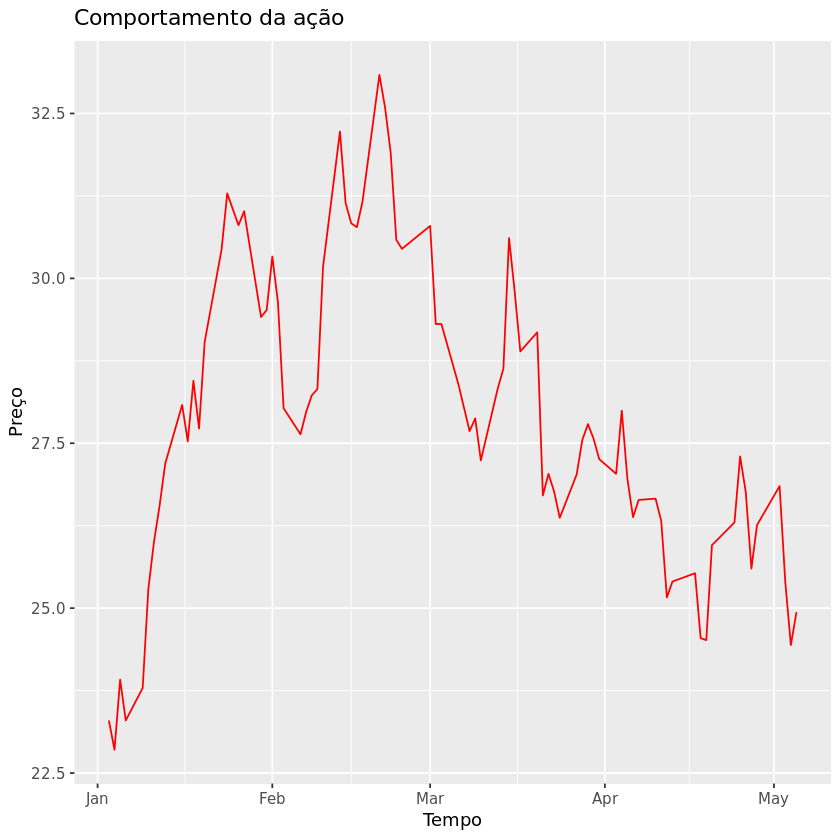

In [19]:
dados_precos %>%
    filter( acao == "VALE5.SA" ) %>% 
    ggplot( aes(x = data, y = preco ) ) +
        geom_line( colour="red" ) +
        xlab("Tempo") + 
        ylab("Preço") +
        ggtitle("Comportamento da ação")

## Gráfico de Barras

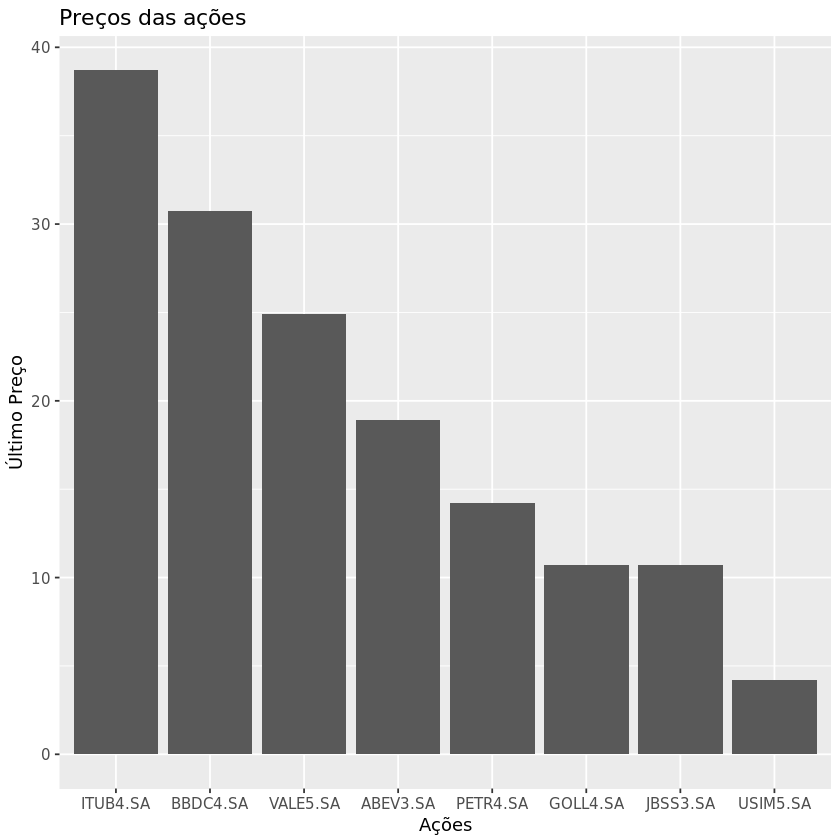

In [26]:
# Ordenar ação mais cara a mais barata
dados_precos %>% 
    filter( acao != "BVSP") %>% 
    group_by(acao) %>% 
    summarize( ultimo_preco = last(preco) ) %>% 
    ggplot( ., aes(x = reorder( acao, -ultimo_preco ), y = ultimo_preco ) ) +
    geom_bar(stat="identity") +
    xlab("Ações") + 
    ylab("Último Preço") +
    ggtitle("Preços das ações")


## Gráfico de Dispersão

### Exemplo 1 - relação entre variáveis

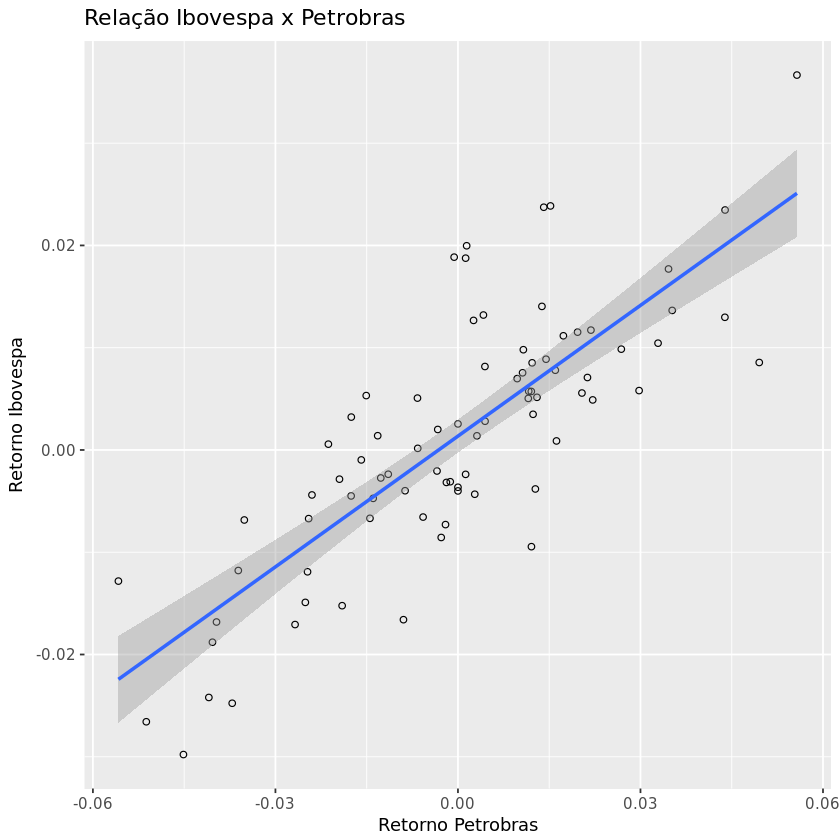

In [32]:
# Retorno de Bovespa e Petrobras, será que existe relação?

dados_precos %>% 
    filter( acao %in% c("BVSP", "PETR4.SA") ) %>%
    select( -preco ) %>% 
    spread( key = acao, value = variacao ) %>% 
    ggplot( aes( x = PETR4.SA, y = BVSP ) ) +
    geom_point( shape = 1 ) +
    geom_smooth( method = lm ) +
    xlab("Retorno Petrobras") + 
    ylab("Retorno Ibovespa") +
    ggtitle("Relação Ibovespa x Petrobras")

### Exemplo 2 - Relação Retorno e Risco das ações

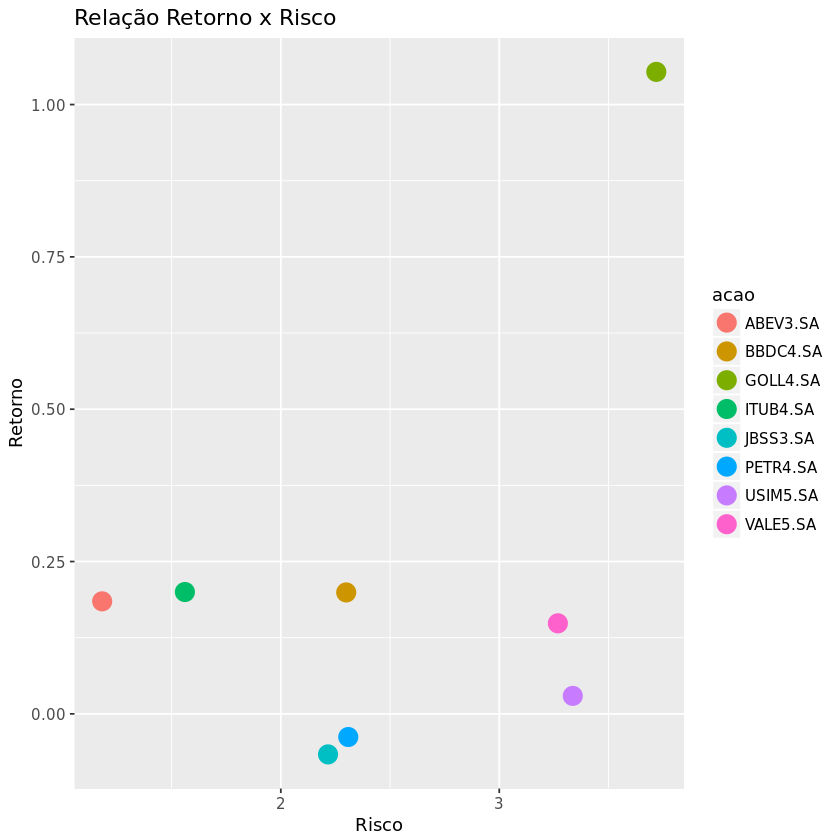

In [54]:
# Qual ação será melhor para investir?
dados_precos %>% 
    filter( acao != "BVSP") %>%
    group_by(acao) %>% 
    summarize( retorno = round( mean(variacao)*100, 4),
               risco = round( sd(variacao)*100, 4) ) %>% 
    ggplot( aes( x = risco, y = retorno, color = acao ) ) +
         geom_point( size = 5 ) +
         xlab("Risco") + 
         ylab("Retorno") +
         ggtitle("Relação Retorno x Risco")
